In [1]:
function string:split( inSplitPattern, outResults )
  if not outResults then
    outResults = { }
  end
  local theStart = 1
  local theSplitStart, theSplitEnd = string.find( self, inSplitPattern, 
theStart )
  while theSplitStart do
    table.insert( outResults, string.sub( self, theStart, theSplitStart-1 ) )
    theStart = theSplitEnd + 1
    theSplitStart, theSplitEnd = string.find( self, inSplitPattern, theStart )
  end
  table.insert( outResults, string.sub( self, theStart ) )
  return outResults
end

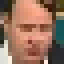

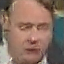

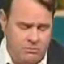

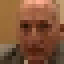

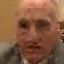

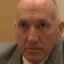

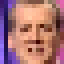

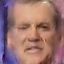

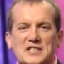

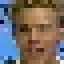

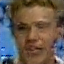

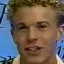

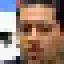

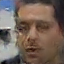

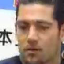

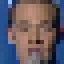

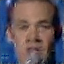

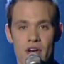

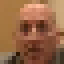

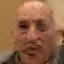

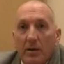

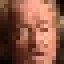

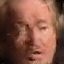

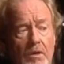

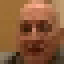

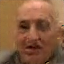

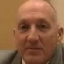

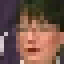

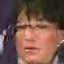

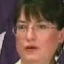

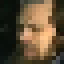

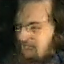

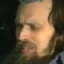

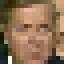

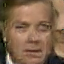

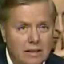

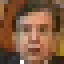

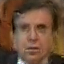

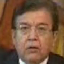

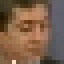

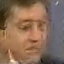

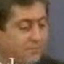

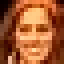

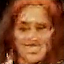

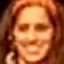

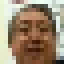

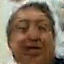

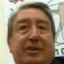

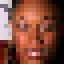

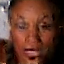

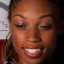

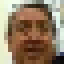

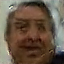

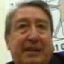

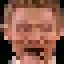

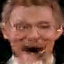

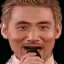

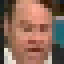

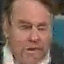

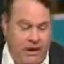

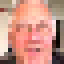

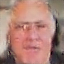

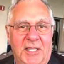

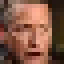

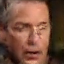

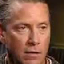

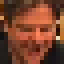

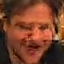

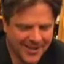

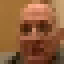

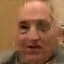

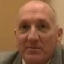

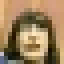

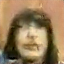

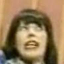

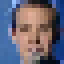

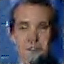

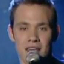

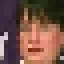

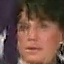

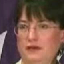

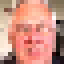

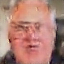

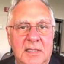

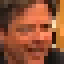

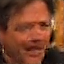

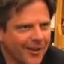

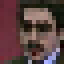

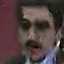

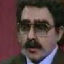

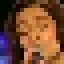

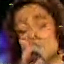

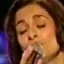

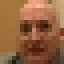

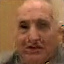

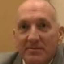


validation error is 0.0411	


In [2]:
require 'image'
require 'nn'

opt = {
    outchan = 3,
    inchan = 3,
    outsize = 64,
    num_frames = 3,
    num_epoch = 10000,
    batchsize = 128,
    valSize = 32,
    gpu = false
}

if opt.outsize == 32 then
    directory = 'small_dataset/'
else
    directory = 'medium_dataset_64/'
end

valvidnames = torch.load(directory .. 'valvidnames.t7')
valimgs = torch.load(directory .. 'valimgs.t7')
vallabels = torch.load(directory .. 'vallabels.t7')

-- generate smaller validation set with previous and subsequent frames
valinputs = torch.FloatTensor(opt.valSize, opt.num_frames * opt.inchan, 16, 16)
valtruths = torch.FloatTensor(opt.valSize, opt.inchan, opt.outsize, opt.outsize)
valresultnames = {}

for vi = 1, opt.valSize do
    local rand_id = torch.random(2, valimgs:size(1) - 1)
    while not (valvidnames[rand_id] == valvidnames[rand_id - 1] and valvidnames[rand_id] == valvidnames[rand_id + 1]) do
        rand_id = torch.random(2, valimgs:size(1) - 1)
    end
    valinputs[vi] = torch.cat(valimgs[rand_id - 1], valimgs[rand_id], 1):cat(valimgs[rand_id + 1], 1)
    valtruths[vi] = vallabels[rand_id]
    table.insert(valresultnames, rand_id)
end
-- for vi = 1, 4 do
--     itorch.image(valinputs[vi])
--     itorch.image(valtruths[vi])
-- end

genl1 = torch.load('small_dataset_64/srez_model_gen_16_to_64.t7')
gen = torch.load('srez_model_gen_final.t7')
outputsl1 = genl1:forward(valinputs)
outputs = gen:forward(valinputs)
criterion = nn.AbsCriterion()

for vi = 1, opt.valSize do
    itorch.image(image.scale(valinputs[{vi, {4,6}, {}, {}}], 64, 64, 'simple'))
    itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
    itorch.image(image.scale(valtruths[vi], 64, 64, 'simple'))
    image.save('results/final_outputs/' .. valresultnames[vi] .. '.f-1.png', image.scale(valinputs[{vi, {1,3}, {}, {}}], 128, 128, 'simple'))
    image.save('results/final_outputs/' .. valresultnames[vi] .. '.f0.png', image.scale(valinputs[{vi, {4,6}, {}, {}}], 128, 128, 'simple'))
    image.save('results/final_outputs/' .. valresultnames[vi] .. '.f+1.png', image.scale(valinputs[{vi, {7,9}, {}, {}}], 128, 128, 'simple'))
    image.save('results/final_outputs/' .. valresultnames[vi] .. '.output.png', image.scale(outputs[vi], 128, 128, 'simple'))
    image.save('results/final_outputs/' .. valresultnames[vi] .. '.outputl1.png', image.scale(outputsl1[vi], 128, 128, 'simple'))
    image.save('results/final_outputs/' .. valresultnames[vi] .. '.truth.png', image.scale(valtruths[vi], 128, 128, 'simple'))
end
valerr = criterion:forward(outputs, valtruths)
print(('\nvalidation error is %.4f'):format(valerr))
